# Token classification

## Load Arabic_POS dataset

Start by loading the arabic_POS dataset from the pyconll library:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyconll
from datasets import Dataset, DatasetDict
import random
from transformers import AutoTokenizer
from transformers import TFAutoModelForTokenClassification , DataCollatorForTokenClassification
from sklearn.model_selection import train_test_split
import evaluate
import tensorflow as tf
from transformers.keras_callbacks import KerasMetricCallback

In [2]:
df = pyconll.load_from_file("/content/Arabic_POS.conllu")

## Preprocess

A: Extract sentences and their corresponding UPOS tags

In [3]:
labels=[]
sentences=[]

for sentence in df:
  tokens = [token.form for token in sentence]
  pos = [token.upos for token in sentence]
  sentences.append(tokens)
  labels.append(pos)

print(f'Sentences =  {len(sentences)}.')
print(f'Labels =  {len(labels)}.')


Sentences =  6075.
Labels =  6075.


In [4]:
print(sentences[0])
print(labels[0])

['برلين', 'ترفض', 'حصول', 'شركة', 'اميركية', 'على', 'رخصة', 'تصنيع', 'دبابة', '"', 'ليوبارد', '"', 'الالمانية']
['X', 'VERB', 'NOUN', 'NOUN', 'ADJ', 'ADP', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'X', 'PUNCT', 'ADJ']


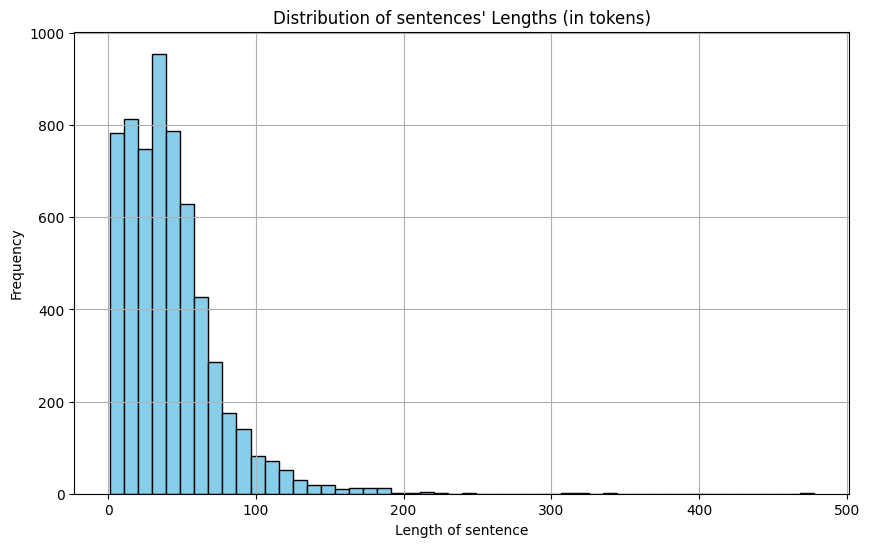

Max length: 478
96th percentile: 153
Median length: 37


In [5]:
seq_lengths = [len(seq) for seq in sentences]

plt.figure(figsize=(10, 6))
plt.hist(seq_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of sentences' Lengths (in tokens)")
plt.xlabel("Length of sentence")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(f"Max length: {np.max(seq_lengths)}")
print(f"96th percentile: {int(np.percentile(seq_lengths, 99))}")
print(f"Median length: {int(np.median(seq_lengths))}")

In [6]:
long_sentences = [s for s in sentences if len(s) > 153]
print(f"Sentences longer than 150 word: {len(long_sentences)} / {len(sentences)} sentences")

Sentences longer than 150 word: 60 / 6075 sentences


The next step is to load a BERT tokenizer to preprocess the `tokens` field:

In [7]:
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


B: Build label mapping

In [8]:
unique_labels = sorted(set(l for label_seq in labels for l in label_seq if l is not None))
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}
num_labels = len(label2id)
print(f"Found {num_labels} unique labels.")
print("Label mapping:", label2id)

Found 17 unique labels.
Label mapping: {'ADJ': 0, 'ADP': 1, 'ADV': 2, 'AUX': 3, 'CCONJ': 4, 'DET': 5, 'INTJ': 6, 'NOUN': 7, 'NUM': 8, 'PART': 9, 'PRON': 10, 'PROPN': 11, 'PUNCT': 12, 'SCONJ': 13, 'SYM': 14, 'VERB': 15, 'X': 16}


C: Tokenize & align tokens with POS labels

In [9]:
def tokenize_and_align_labels(tokens, labels):
    tokenized_inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        truncation=True,
        padding='max_length',
        max_length=153
    )

    word_ids = tokenized_inputs.word_ids()
    aligned_labels = []
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            aligned_labels.append(-100)
        elif word_idx != previous_word_idx:
            label = labels[word_idx]
            aligned_labels.append(label2id.get(label, -100))
        else:
            aligned_labels.append(-100)
        previous_word_idx = word_idx

    tokenized_inputs['labels'] = aligned_labels
    return tokenized_inputs




---







To apply the preprocessing function over the entire dataset, use 🤗 Datasets [map]You can speed up the `map` function by setting `batched=True` to process multiple elements of the dataset at once:

In [10]:
# Combine tokens and labels into a list of dicts
data = [{'tokens': s, 'labels': l} for s, l in zip(sentences, labels)]

# train: 80% , val: 10% , Test:10
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=88)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=88)

# Apply tokenization
tokenized_train = [tokenize_and_align_labels(item['tokens'], item['labels']) for item in train_data]
tokenized_val = [tokenize_and_align_labels(item['tokens'], item['labels']) for item in val_data]
tokenized_test = [tokenize_and_align_labels(item['tokens'], item['labels']) for item in test_data]

#Build Hugging Face DatasetDict
dataset = DatasetDict({
    'train': Dataset.from_list(tokenized_train),
    'validation': Dataset.from_list(tokenized_val),
    'test': Dataset.from_list(tokenized_test)
})



In [11]:
data_collator = DataCollatorForTokenClassification(tokenizer)

## Evaluate

Including a metric during training is often helpful for evaluating your model's performance. You can quickly load a evaluation method with the 🤗 [Evaluate] ,  Seqeval actually produces several scores: precision, recall, F1, and accuracy.

In [12]:
seqeval = evaluate.load("seqeval")

Get the POS labels first, and then create a function that passes your true predictions and true labels to [compute] to calculate the scores:

In [13]:
unique_labels

['ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'SYM',
 'VERB',
 'X']

In [14]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [unique_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [unique_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

Your `compute_metrics` function is ready to go now, and you'll return to it when you setup your training.

## Train

In [15]:
from transformers import create_optimizer

batch_size = 16
num_train_epochs = 3
num_train_steps = (len(tokenized_train) // batch_size) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    num_warmup_steps=0,
)

Then you can load BERT-base-arabic with [TFAutoModelForTokenClassification](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.TFAutoModelForTokenClassification) along with the number of expected labels, and the label mappings:

In [16]:
model = TFAutoModelForTokenClassification.from_pretrained(
    "asafaya/bert-base-arabic",
    num_labels=num_labels
)

model.config.id2label = id2label
model.config.label2id = label2id


All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Convert your datasets to the `tf.data.Dataset` format with [prepare_tf_dataset()](https://huggingface.co/docs/transformers/main/en/main_classes/model#transformers.TFPreTrainedModel.prepare_tf_dataset):

In [17]:
tf_train_set = model.prepare_tf_dataset(
    dataset['train'],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    dataset['validation'],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)
tf_test_set = model.prepare_tf_dataset(
    dataset['test'],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

Configure the model for training with [`compile`](https://keras.io/api/models/model_training_apis/#compile-method). Note that Transformers models all have a default task-relevant loss function, so you don't need to specify one unless you want to:

In [18]:
model.compile(optimizer=optimizer)  # No loss argument!

Pass your `compute_metrics` function to [KerasMetricCallback](https://huggingface.co/docs/transformers/main/en/main_classes/keras_callbacks#transformers.KerasMetricCallback):

In [19]:
metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

Finally, you're ready to start training your model! Call [`fit`](https://keras.io/api/models/model_training_apis/#fit-method) with your training and validation datasets, the number of epochs, and your callbacks to finetune the model:

In [20]:
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3, callbacks=metric_callback)

Epoch 1/3
303/303 [==============================] - ETA: 0s - loss: 0.3798

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: CCONJ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PART seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VERB seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ADJ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ADP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171:

303/303 [==============================] - 191s 567ms/step - loss: 0.3798 - val_loss: 0.1301 - precision: 0.9541 - recall: 0.9490 - f1: 0.9516 - accuracy: 0.9657
Epoch 2/3
303/303 [==============================] - 168s 553ms/step - loss: 0.1131 - val_loss: 0.1152 - precision: 0.9587 - recall: 0.9546 - f1: 0.9567 - accuracy: 0.9690
Epoch 3/3
303/303 [==============================] - 167s 551ms/step - loss: 0.0911 - val_loss: 0.1102 - precision: 0.9600 - recall: 0.9560 - f1: 0.9580 - accuracy: 0.9701


In [21]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

## Inference

Great, now that you've finetuned a model, you can use it for inference!

Grab some text you'd like to run inference on:

In [22]:
model.save_pretrained("my-arabic-pos-model")
tokenizer.save_pretrained("my-arabic-pos-model")


('my-arabic-pos-model/tokenizer_config.json',
 'my-arabic-pos-model/special_tokens_map.json',
 'my-arabic-pos-model/vocab.txt',
 'my-arabic-pos-model/added_tokens.json',
 'my-arabic-pos-model/tokenizer.json')

In [27]:
!zip -r my-arabic-pos-model.zip my-arabic-pos-model


  adding: my-arabic-pos-model/ (stored 0%)
  adding: my-arabic-pos-model/config.json (deflated 54%)
  adding: my-arabic-pos-model/vocab.txt (deflated 63%)
  adding: my-arabic-pos-model/special_tokens_map.json (deflated 42%)
  adding: my-arabic-pos-model/tokenizer.json (deflated 73%)
  adding: my-arabic-pos-model/tokenizer_config.json (deflated 74%)
  adding: my-arabic-pos-model/tf_model.h5 (deflated 7%)


In [28]:
from google.colab import files
files.download("my-arabic-pos-model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
id2label = {
    0: 'ADJ', 1: 'ADP', 2: 'ADV', 3: 'AUX', 4: 'CCONJ',
    5: 'DET', 6: 'INTJ', 7: 'NOUN', 8: 'NUM', 9: 'PART',
    10: 'PRON', 11: 'PROPN', 12: 'PUNCT', 13: 'SCONJ',
    14: 'SYM', 15: 'VERB', 16: 'X'
}
label2id = {v: k for k, v in id2label.items()}

Arabic Label Mapping

In [24]:
label_mapping = {
    'ADJ': 'صفة',
    'ADP': 'حرف جر',
    'ADV': 'ظرف',
    'AUX': 'فعل مساعد',
    'CCONJ': 'أداة ربط',
    'DET': 'أداة تعريف',
    'INTJ': 'تعجب',
    'NOUN': 'اسم',
    'NUM': 'عدد',
    'PART': 'أداة',
    'PRON': 'ضمير',
    'PROPN': 'اسم علم',
    'PUNCT': 'علامة ترقيم',
    'SCONJ': 'أداة ربط',
    'SYM': 'رمز',
    'VERB': 'فعل',
    'X': 'مجهول'
}


Get the class with the highest probability, and use the model's `id2label` mapping to convert it to a text label:

### Function to predict the POS of each token

In [25]:
def predict_pos(text, model_path):
    # Load tokenizer + fine-tuned model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = TFAutoModelForTokenClassification.from_pretrained(model_path)

    inputs = tokenizer(text, return_tensors="tf", truncation=True, is_split_into_words=False)
    # Get model outputs
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_token_class_ids = tf.math.argmax(logits, axis=-1)[0].numpy()
    # Convert token IDs back to tokens
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Build result list with Arabic labels and handle subwords
    results = []
    current_word = ''
    current_label = None
    for token, pred_id in zip(tokens, predicted_token_class_ids):
        if token in ['[CLS]', '[SEP]', '[PAD]']:
            continue

        if token.startswith('##'):
            # If it's a subword token, append to the current word
            current_word += token[2:]  # Remove the '##' part
        else:
            # If it's a new word, finalize the current word (if any)
            if current_word:
                # Append the previous word and its label
                results.append((current_word, model.config.id2label[current_label]))
            # Start a new word
            current_word = token
            current_label = pred_id

    # Add the last word (if any)
    if current_word:
        results.append((current_word, model.config.id2label[current_label]))

    # Convert the English labels to Arabic labels
    results_with_arabic_labels = [(word, label_mapping.get(label, label)) for word, label in results]

    return results_with_arabic_labels


In [26]:
text = "أنا ذهبت الي المنزل الساعة الثالثة و تناولت الغداء و احتسيت العصير ثم ذهبت الي النوم"

predictions = predict_pos(text, "my-arabic-pos-model")

for word, label in predictions:
    print(f"{word} → {label}")


Some layers from the model checkpoint at my-arabic-pos-model were not used when initializing TFBertForTokenClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForTokenClassification were initialized from the model checkpoint at my-arabic-pos-model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForTokenClassification for predictions without further training.
Asking to truncate to max_length but no maximum length is provided and the model has n

انا → مجهول
ذهبت → فعل
الي → حرف جر
المنزل → اسم
الساعة → اسم
الثالثة → صفة
و → أداة ربط
تناولت → فعل
الغداء → اسم
و → أداة ربط
احتسيت → فعل
العصير → اسم
ثم → أداة ربط
ذهبت → فعل
الي → حرف جر
النوم → اسم
